The purpose of this script is to find out whether anomalies in water vapor are correlated to anomalies in cloud condensate

In [11]:
import typhon
import pickle
import numpy as np
import analysis_tools as atools
import matplotlib.pyplot as plt
from importlib import reload
from os.path import join
from netCDF4 import Dataset
from moisture_space import plots
from scipy.interpolate import interp2d
from moisture_space import moisture_space, plots

# Config

In [99]:
models = ['ICON', 'NICAM', 'GEOS', 'IFS', 'SAM', 'FV3', 'MPAS', 'UM', 'ARPEGE']
runs = {
    'ICON': ['2.5km'],
    'NICAM': ['3.5km'],
    'SAM': ['4.0km'],
    'UM': ['5.0km'],
    'FV3': ['3.25km'],
    'GEOS': ['3.0km'],
    'IFS': ['4.0km', '9.0km'],
    'MPAS': ['3.75km'],
    'ARPEGE': ['2.5km'],
    'ERA5': ['31.0km']
}
exps = []
for m in models:
    for run in runs[m]:
        exps.append(m+'-'+run)
        
time_period = ['0810', '0908']
variables_3D = ['TEMP', 'PRES', 'QV', 'RH', 'W', 'QI', 'QC']
variables_2D = ['IWV']
datapath = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/{}/random_samples/'
scenarios = sample_days+ocean_basins
filenames = '{}-{}_{}_sample_{}_{}-{}{}.nc'
num_profiles = int(1 * 1e7)
perc_values = np.arange(1., 100.5, 1.0)
num_percs = len(perc_values)
iwv_bin_bnds = np.arange(0, 101, 1)
bin_values = iwv_bin_bnds[:-1] + 0.5 * np.diff(iwv_bin_bnds)
bins = range(len(iwv_bin_bnds) - 1) 
h = np.arange(100, 17600, 200) # height vector to interpolate all models on
height = {}
num_levels = {}
for m in models:
    for run in runs[m]:
        key = m+'-'+run
        filename = filenames.format(m, run, variables_3D[0], num_profiles, time_period[0], time_period[1], '')
        if run == '2.5km_winter':
            filename = filenames.format(m, run, variables_3D[0], num_profiles, '0120', '0202')
        if m == 'ERA5':
            filename = f'/mnt/lustre02/work/mh1126/m300773/DYAMOND/ERA5/2016/random_samples/{filename}'
        else:
            filename = join(datapath.format(m), filename)
        with(Dataset(filename)) as ds:
            height[key] = ds.variables['height'][:].filled(np.nan)
        num_levels[key] = len(height[key])
plt.style.use(typhon.plots.styles.get('typhon'))        

# Read data

In [100]:
reload(moisture_space)
perc = {}
binned = {}
ms_perc = {}
ms_bins = {}
percentiles = {}
for m in models:
    for run in runs[m]:
        exp = m+'-'+run
        print(exp)
        if m == 'ERA5':
            p = f'{m}/2016'
        else:
            p = m
        ms_perc[exp] = {}
        ms_bins[exp] = {}
        
        path_perc = f'{m}-{run}_{time_period[0]}-{time_period[1]}_perc_means_{num_profiles}_1exp.pkl'
        path_bin = f'{m}-{run}_{time_period[0]}-{time_period[1]}_bin_means_{num_profiles}_1exp.pkl'

        with open(join(datapath.format(p), path_perc), 'rb' ) as infile:
             perc = pickle.load(infile)
        with open(join(datapath.format(p), path_bin), 'rb' ) as infile:
             binned = pickle.load(infile)       
                
        for var in variables_3D:
            stats_perc = moisture_space.ProfileStats.from_dict(perc, var)
            ms_perc[exp][var] = moisture_space.PercMoistureSpace(exp, stats_perc, perc_values, height[exp]).interpolate(h, kind='linear')
            stats_bin = moisture_space.ProfileStats.from_dict(binned, var)
            ms_bins[exp][var] = moisture_space.BinMoistureSpace(exp, stats_bin, bin_values, height[exp], binned['count']).interpolate(h, kind='linear')
            ms_bins[exp][var].remove_empty_bins(number_threshold=300)
        for var in variables_2D:
            stats_perc = moisture_space.ProfileStats.from_dict(perc, var)
            ms_perc[exp][var] = moisture_space.PercMoistureSpace(exp, stats_perc, perc_values, None)   
            stats_bin = moisture_space.ProfileStats.from_dict(binned, var)
            ms_bins[exp][var] = moisture_space.BinMoistureSpace(exp, stats_bin, bin_values, None, binned['count'])
            ms_bins[exp][var].remove_empty_bins(number_threshold=300)

ICON-2.5km
NICAM-3.5km
GEOS-3.0km
IFS-4.0km
IFS-9.0km
SAM-4.0km
FV3-3.25km
MPAS-3.75km
UM-5.0km
ARPEGE-2.5km


In [101]:
for exp in exps:
    # saturation specific humidity
    q_tot = ms_perc[exp]['QI'].mean + ms_perc[exp]['QC'].mean
    ms_perc[exp]['Q_tot'] = moisture_space.PercMoistureSpace.from_mean(q_tot, 'Q_tot', exp, perc_values, h)

In [102]:
ms_perc_series = {}
for var in variables_3D+['Q_tot']:
    perc_space_list = [ms_perc[exp][var] for exp in exps]
    ms_perc_series[var] = moisture_space.MoistureSpaceSeries(perc_space_list)

In [103]:
avars = ['Q_tot', 'QV', 'RH']
a = {v: {} for v in avars}
a_series = {}
for exp in exps:
    a['Q_tot'][exp] = moisture_space.PercMoistureSpace.from_mean(ms_perc[exp]['Q_tot'].mean - ms_perc_series['Q_tot'].mean, 'Q_tot', exp, perc_values, h)
    a['QV'][exp] = moisture_space.PercMoistureSpace.from_mean(ms_perc[exp]['QV'].mean - ms_perc_series['QV'].mean, 'QV', exp, perc_values, h)
    a['RH'][exp] = moisture_space.PercMoistureSpace.from_mean(ms_perc[exp]['RH'].mean - ms_perc_series['RH'].mean, 'RH', exp, perc_values, h)
    
for var in avars:
    perc_space_list = [a[var][exp] for exp in exps]
    a_series[var] = moisture_space.MoistureSpaceSeries(perc_space_list)

In [104]:
corr = {}
corr_pairs = [
    ('Q_tot', 'QV'),
    ('Q_tot', 'RH')
]

for c in corr_pairs:
    pair = moisture_space.MoistureSpaceSeriesPair(a_series[c[0]], a_series[c[1]])
    corr[c] = pair.correlation()

DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af468263a90>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af468305978>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh


Text(0, 0.5, 'Height / km')

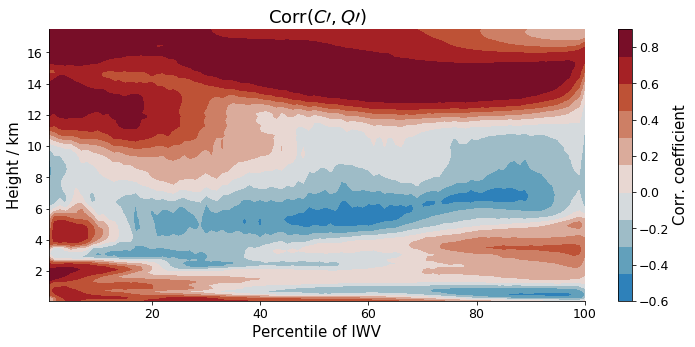

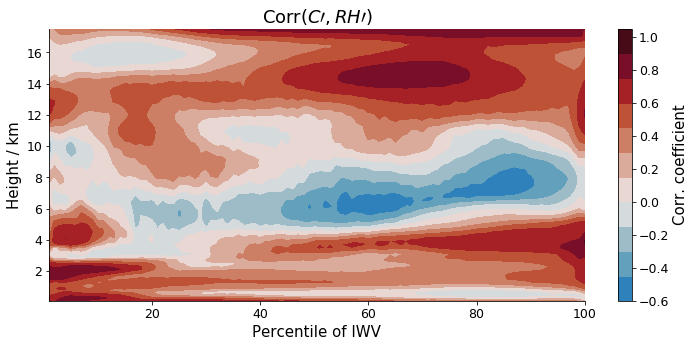

In [105]:
plt.rcParams.update({'font.size': 15})
black_contours = [-0.8, 0.8]

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($C \prime, Q \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('Q_tot', 'QV')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('ta_tot', 'qa')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(r'Corr($C \prime, RH \prime$)')
im = ax.contourf(perc_values, h*1e-3, corr[('Q_tot', 'RH')].T, 10, vmin=-1, vmax=1, cmap='difference')
#ax.contour(perc_values, h*1e-3, corr[('ta_tot', 'qa')].T, black_contours, colors='k')
fig.colorbar(im, orientation='vertical', label='Corr. coefficient', ticks=np.arange(-1, 1.1, 0.2))
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')

DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af467b80908>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh
DEBUG:locator: <matplotlib.ticker.FixedLocator object at 0x2af467bafda0>
DEBUG:Using fixed locator on colorbar
DEBUG:Setting pcolormesh


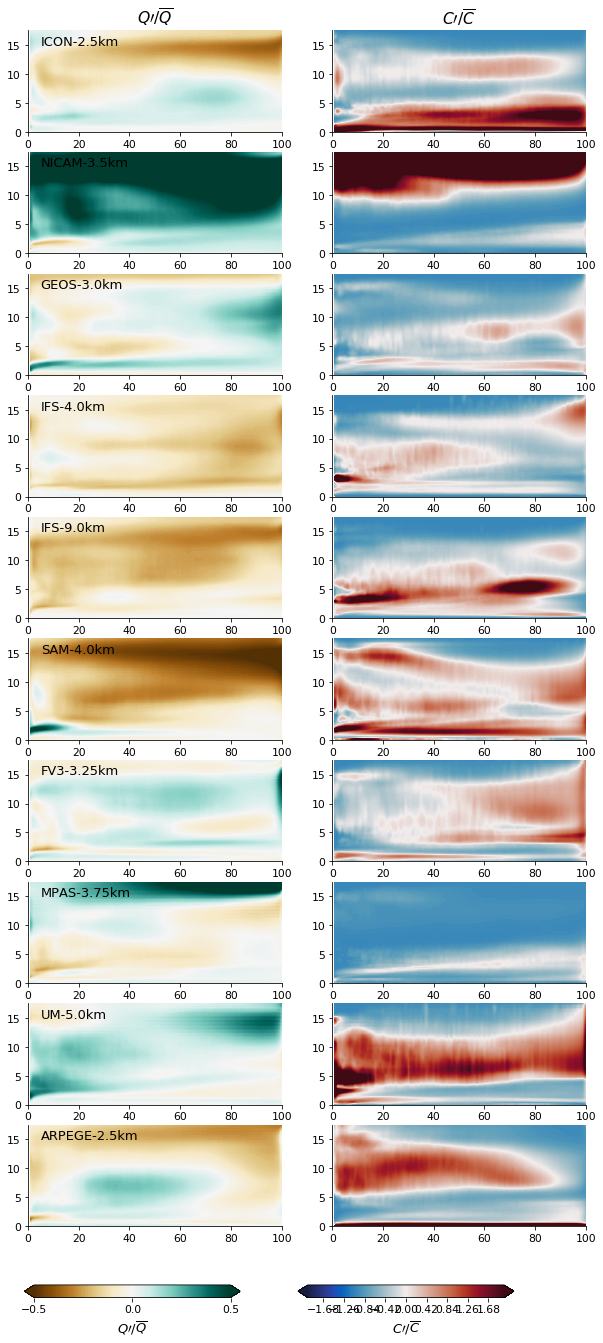

In [88]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(len(exps), 2, figsize=(10, 22))
contours_q = np.arange(-0.5, 0.501, 0.005)
contours_a = np.arange(-2., 2.001, 0.02)
x_lims = [0, 100]
y_lims = [0, 17.5]
for i, exp in enumerate(exps):
    ax[i, 0].annotate(exp, (5, 15))
    imq = plots.moisture_space_contourf(fig, ax[i, 0], perc_values, h * 1e-3, a['QV'][exp].mean.T / ms_perc_series['QV'].mean.T, contours_q,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='BrBG', vmin=contours_q[0], vmax=contours_q[-1])
    imc = plots.moisture_space_contourf(fig, ax[i, 1], perc_values, h * 1e-3, a['Q_tot'][exp].mean.T / ms_perc_series['Q_tot'].mean.T, contours_a,\
                              x_lims, y_lims, '', '', '', cb=False,
                              cm_orientation='vertical', cb_extend='both',\
                              cmap='difference')#, vmin=contours_q[0], vmax=contours_q[-1])

ax[0, 0].set_title(r'$Q \prime / \overline{Q}$')
ax[0, 1].set_title(r'$C \prime / \overline{C}$')


cb_ax = fig.add_axes([0.12, 0.08, 0.3, 0.008])
fig.colorbar(imq, cax=cb_ax, orientation='horizontal', ticks=np.arange(-0.5, 0.501, 0.5), label='$Q \prime / \overline{Q}$')

cb_ax = fig.add_axes([0.5, 0.08, 0.3, 0.008])
fig.colorbar(imc, cax=cb_ax, orientation='horizontal', label=r'$C \prime / \overline{C}$')